In [1]:
# ================== SETUP & IMPORT ==================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
import emoji
import nltk

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFAutoModel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from wordcloud import WordCloud





In [2]:
# ================== CONFIG ==================
SEED = 42

# Set gaya visualisasi seaborn
sns.set_style("whitegrid")

# Konfigurasi default matplotlib
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

# Opsi rc tambahan
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


In [3]:
# ================== LOAD DATA ==================
train_path = 'train_new.csv'
test_path = 'test_new.csv'

df = pd.read_csv(train_path, encoding='ISO-8859-1')       # Data training
df_test = pd.read_csv(test_path, encoding='ISO-8859-1')   # Data testing

# menampilkan 5 baris pertama masing-masing dataset
df.head(), df_test.head()

(                                        cleaned_text    Label
 0  plis ini longlasting banget warnanya juga bagu...  positif
 1  respon seller ok bgt jg pengiriman nya kilat m...   netral
 2                                      produk seauai   netral
 3  recommended ya aroma parfumnya ada kopi2 nya g...  negatif
 4  pengemasan aman pengiriman sesuai dengan perki...   netral,
                                         cleaned_text    Label
 0  merek favorit untuk make up so far cocok harga...  positif
 1  lip glazed ini bener2 ngecover bibir gelap ku ...   netral
 2  bagus si packing an nya aman tapi kok pas aku ...  negatif
 3             pengemasan pengiriman cepat paket rapi   netral
 4  barang sesuai pesanan semoga cocok sama jenis ...   netral)

In [4]:
import os
print(os.path.exists(train_path))  # harus True
print(os.path.getsize(train_path)) # harus > 0


True
192633


In [5]:
print(df.head())
print(df.columns)
print(len(df))


                                        cleaned_text    Label
0  plis ini longlasting banget warnanya juga bagu...  positif
1  respon seller ok bgt jg pengiriman nya kilat m...   netral
2                                      produk seauai   netral
3  recommended ya aroma parfumnya ada kopi2 nya g...  negatif
4  pengemasan aman pengiriman sesuai dengan perki...   netral
Index(['cleaned_text', 'Label'], dtype='object')
2324


In [6]:
with open(train_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        print(i, line)
        if i >= 5:
            break


0 cleaned_text,Label

1 plis ini longlasting banget warnanya juga bagus banget bgt kalo di ombre in sama skye best combo teksturnya jg ringan will b my fav lip product,positif

2 respon seller ok bgt jg pengiriman nya kilat malam order bsk sore lsg sampe makasih,netral

3 produk seauai,netral

4 recommended ya aroma parfumnya ada kopi2 nya gitu lumayan tahan sekitar 12 jam an dan wanginya beda aja botolnta mungil bisa masuk dalam tas kecil sekali pun terimak,negatif

5 pengemasan aman pengiriman sesuai dengan perkiraan barang baru pertama kali coba semoga cocok,netral



In [7]:
train_path = 'train2.csv'
test_path = 'test2.csv'

# Load CSV dengan utf-8 dan periksa separator
df = pd.read_csv(train_path, encoding='utf-8', quotechar='"')
df_test = pd.read_csv(test_path, encoding='utf-8', quotechar='"')

# Cek isi dan kolom
print(df.head())
print(df.columns)
print(len(df))


                                              Ulasan  Label  \
0                                               nice      1   
1   sukaaaaaaaaaa bangetttttttttt next mau beli lagi      1   
2                                             mantap      1   
3                            endulbat ini produkð¥°      1   
4  katanya PO 10 hari tapiiii kmrn baru mesan har...      2   

                                        cleaned_text  
0                                               nice  
1   sukaaaaaaaaaa bangetttttttttt next mau beli lagi  
2                                             mantap  
3                                endulbat ini produk  
4  katanya po 10 hari tapiiii kmrn baru mesan har...  
Index(['Ulasan', 'Label', 'cleaned_text'], dtype='object')
3234


In [8]:
print("Jumlah data awal:", len(df))
print(df.head())
print(df.columns)
print(df['Label'].value_counts())


Jumlah data awal: 3234
                                              Ulasan  Label  \
0                                               nice      1   
1   sukaaaaaaaaaa bangetttttttttt next mau beli lagi      1   
2                                             mantap      1   
3                            endulbat ini produkð¥°      1   
4  katanya PO 10 hari tapiiii kmrn baru mesan har...      2   

                                        cleaned_text  
0                                               nice  
1   sukaaaaaaaaaa bangetttttttttt next mau beli lagi  
2                                             mantap  
3                                endulbat ini produk  
4  katanya po 10 hari tapiiii kmrn baru mesan har...  
Index(['Ulasan', 'Label', 'cleaned_text'], dtype='object')
Label
1    2450
2     745
0      39
Name: count, dtype: int64


In [9]:
# ======================Data Preprocessing=============================
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # hapus emoji
    emoji_pattern = re.compile("[" 
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # hapus mention, url, karakter non-ascii
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    # hapus tanda baca
    import string
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)

    # hapus hashtag
    text = re.sub(r'#\w+\b', '', text)
    text = text.replace("#", "")

    # hapus kata yang ada $ atau &
    text = " ".join("" if ('$' in word or '&' in word) else word for word in text.split())

    # rapikan spasi
    text = re.sub("\s\s+" , " ", text)

    return text.strip()


<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
C:\Users\nnlau\AppData\Local\Temp\ipykernel_5432\3345757743.py:34: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub("\s\s+" , " ", text)


In [10]:
print("Jumlah data akhir setelah cleaning:", len(df))
print(df.head())
print("Distribusi Label:\n", df['Label'].value_counts())


Jumlah data akhir setelah cleaning: 3234
                                              Ulasan  Label  \
0                                               nice      1   
1   sukaaaaaaaaaa bangetttttttttt next mau beli lagi      1   
2                                             mantap      1   
3                            endulbat ini produkð¥°      1   
4  katanya PO 10 hari tapiiii kmrn baru mesan har...      2   

                                        cleaned_text  
0                                               nice  
1   sukaaaaaaaaaa bangetttttttttt next mau beli lagi  
2                                             mantap  
3                                endulbat ini produk  
4  katanya po 10 hari tapiiii kmrn baru mesan har...  
Distribusi Label:
 Label
1    2450
2     745
0      39
Name: count, dtype: int64


In [11]:
# ================== CLEANING DATA ==================
df['cleaned_text'] = df['Ulasan'].fillna("")
df_test['cleaned_text'] = df_test['Ulasan'].fillna("")

df['text_clean'] = df['cleaned_text'].apply(clean_text)
df_test['text_clean'] = df_test['cleaned_text'].apply(clean_text)

df.drop_duplicates(subset='text_clean', inplace=True)
df['text_len'] = df['text_clean'].apply(lambda x: len(x.split()))
df_test['text_len'] = df_test['text_clean'].apply(lambda x: len(x.split()))

# Jangan terlalu keras, coba > 1 dulu
df = df[df['text_len'] > 1]
df_test = df_test[df_test['text_len'] > 1]


In [12]:
print(df['Label'].unique())


[1 2 0]


In [13]:
print(df['Label'].unique())
print(df['Label'].isna().sum())


[1 2 0]
0


In [14]:
print(df.columns)


Index(['Ulasan', 'Label', 'cleaned_text', 'text_clean', 'text_len'], dtype='object')


In [15]:
# Cek jumlah NaN
print("NaN di cleaned_text:", df['cleaned_text'].isna().sum())
print("NaN di Label:", df['Label'].isna().sum())


NaN di cleaned_text: 0
NaN di Label: 0


In [16]:
df = df.dropna(subset=['cleaned_text'])


In [17]:
df['cleaned_text'] = df['cleaned_text'].fillna('')


In [18]:
# ================== BALANCE DATA ==================
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Hapus NaN dulu
df = df.dropna(subset=['cleaned_text'])

ros = RandomOverSampler(random_state=SEED)
X_os, y_os = ros.fit_resample(df['cleaned_text'].values.reshape(-1,1), df['Label'].values)

train_os = pd.DataFrame({
    'cleaned_text': X_os.flatten(),
    'Label': y_os
})


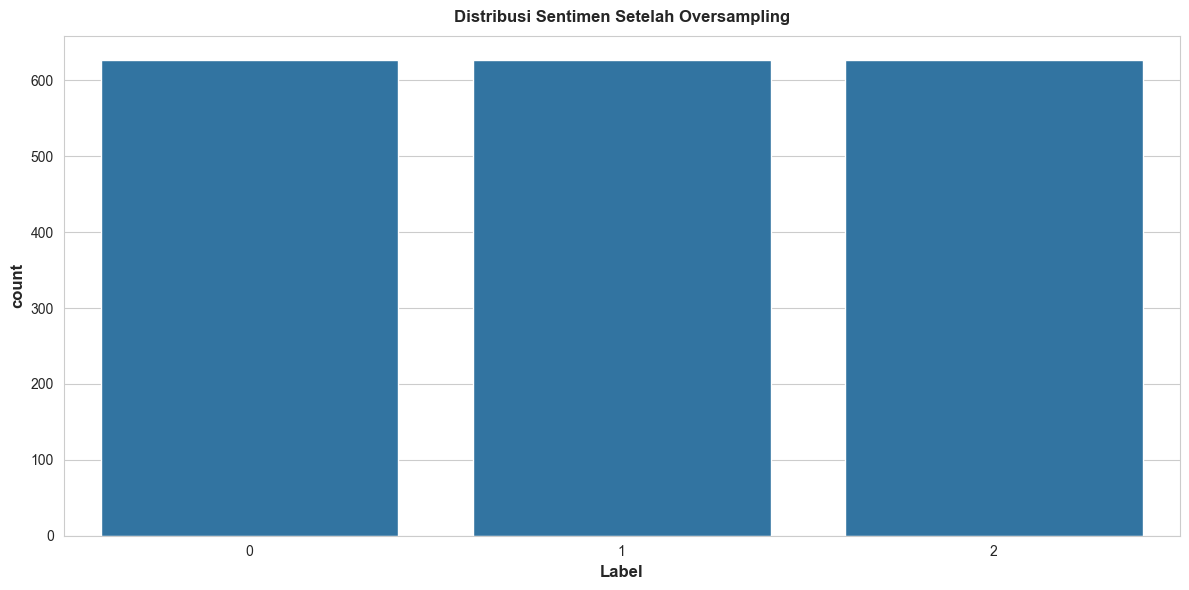

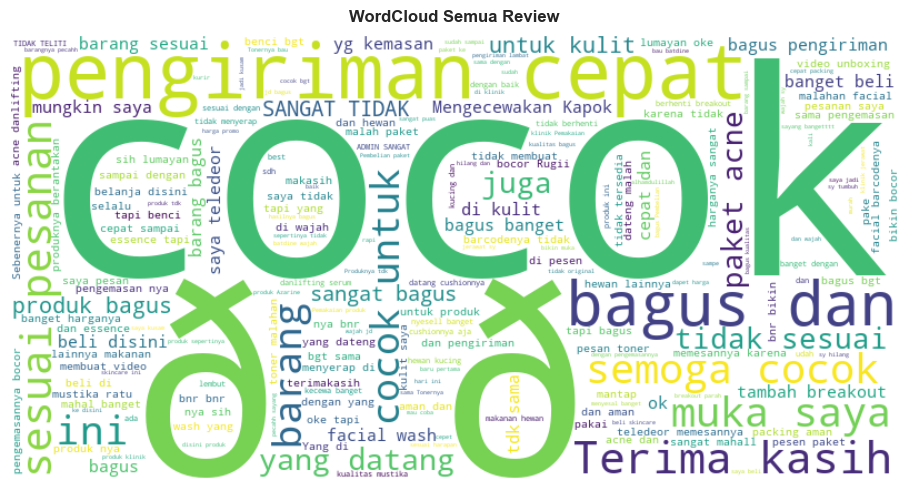

In [19]:
# ================== EDA ==================
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Distribusi label setelah balancing
sns.countplot(x=train_os['Label'])
plt.title("Distribusi Sentimen Setelah Oversampling")
plt.show()

# WordCloud semua review
text_all = " ".join(train_os['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud Semua Review")
plt.show()

In [20]:
# ================== SPLIT TRAIN & VALIDATION ==================
# Train (80%), Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    train_os['cleaned_text'], train_os['Label'],
    test_size=0.2, stratify=train_os['Label'], random_state=SEED
)

# Temp dibagi jadi Valid (10%) dan Test (10%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, stratify=y_temp, random_state=SEED
)


In [21]:
# Pastikan max_len sudah didefinisikan
max_len = 128  # Atau gunakan nilai yang sama seperti pada tahap tokenisasi

def build_model(model_name, num_labels, max_len=128):
    from transformers import TFAutoModel
    
    indobert = TFAutoModel.from_pretrained(model_name)

    input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    outputs = indobert(input_ids=input_ids, attention_mask=attention_mask)

    # ambil last hidden state
    last_hidden_state = outputs.last_hidden_state
    cls_token = last_hidden_state[:, 0, :]  # [CLS] token

    out = tf.keras.layers.Dense(num_labels, activation="softmax")(cls_token)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=out)
    return model


In [22]:
# TOKENISASI
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
max_len = 128
def encode_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='tf'
    )
train_enc = encode_texts(X_train.astype(str).tolist(), tokenizer, max_len)
valid_enc = encode_texts(X_valid.astype(str).tolist(), tokenizer, max_len)
test_enc  = encode_texts(X_test.astype(str).tolist(), tokenizer, max_len)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [23]:
# ================MODEL========================
from transformers import AutoTokenizer, TFBertForSequenceClassification

# Tentukan model IndoBERT
MODEL_NAME = "indobenchmark/indobert-base-p1"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model untuk klasifikasi (3 kelas)
num_labels = 3
model = TFBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# ================== EVALUASI SEBELUM FINE-TUNING ==================
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

print("\n=== Evaluasi sebelum fine-tuning ===")

# Prediksi
y_pred_probs_before = model.predict({
    "input_ids": test_enc["input_ids"],
    "attention_mask": test_enc["attention_mask"]
}, batch_size=64)

# Ambil kelas prediksi
y_pred_before = np.argmax(y_pred_probs_before.logits, axis=1)

# Hasil evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred_before))
print(classification_report(y_test, y_pred_before, digits=4))



=== Evaluasi sebelum fine-tuning ===
3/3 [==============================] - 18s 4s/step
Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        63
           1     0.3478    0.7619    0.4776        63
           2     0.2941    0.2381    0.2632        63

    accuracy                         0.3333       189
   macro avg     0.2140    0.3333    0.2469       189
weighted avg     0.2140    0.3333    0.2469       189



d:\Analisis Opini Skincarefix\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Analisis Opini Skincarefix\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Analisis Opini Skincarefix\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

In [25]:
from transformers import create_optimizer
import tensorflow as tf
import matplotlib.pyplot as plt

# ====================
# 1. Hyperparameter
# ====================
EPOCHS = 3  
BATCH_SIZE = 32
steps_per_epoch = len(X_train) // BATCH_SIZE
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = num_train_steps // 10  # warmup 10%

# ====================
# 2. Optimizer
# ====================
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=num_warmup_steps,
    num_train_steps=num_train_steps
)

# ====================
# 3. Compile Model
# ====================
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# ====================
# 4. Training
# ====================
history = model.fit(
    {"input_ids": train_enc["input_ids"], "attention_mask": train_enc["attention_mask"]},
    y_train,
    validation_data=(
        {"input_ids": valid_enc["input_ids"], "attention_mask": valid_enc["attention_mask"]},
        y_valid
    ),

    
    
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)



Epoch 1/3


47/47 [==============================] - 368s 7s/step - loss: 0.5160 - accuracy: 0.8052 - val_loss: 0.0763 - val_accuracy: 0.9681
Epoch 2/3
47/47 [==============================] - 333s 7s/step - loss: 0.0276 - accuracy: 0.9960 - val_loss: 0.0295 - val_accuracy: 0.9947
Epoch 3/3
47/47 [==============================] - 332s 7s/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0339 - val_accuracy: 0.9947


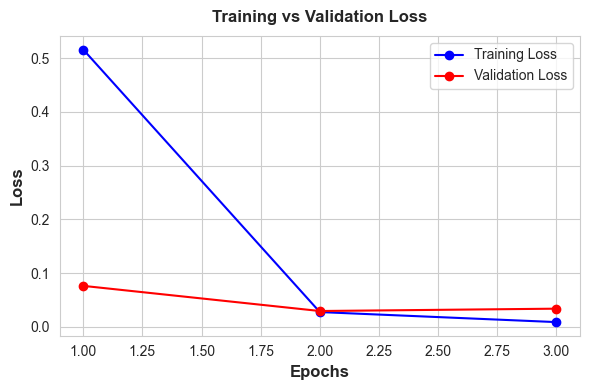

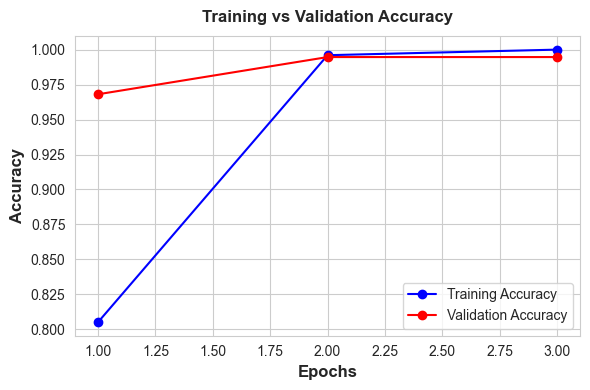

In [26]:
import matplotlib.pyplot as plt

# Ambil nilai dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot Los

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



=== Evaluasi setelah fine-tuning ===
6/6 [==============================] - 16s 2s/step
Accuracy: 0.9894179894179894
              precision    recall  f1-score   support

    Negative     0.9844    1.0000    0.9921        63
     Neutral     1.0000    0.9683    0.9839        63
    Positive     0.9844    1.0000    0.9921        63

    accuracy                         0.9894       189
   macro avg     0.9896    0.9894    0.9894       189
weighted avg     0.9896    0.9894    0.9894       189



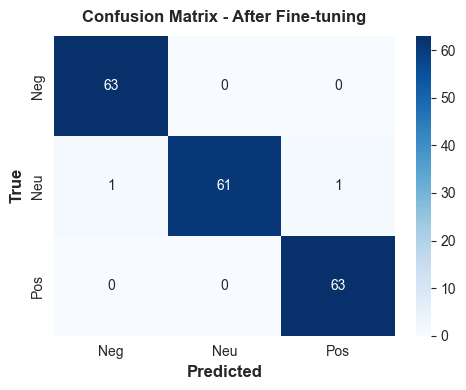

In [27]:

# =============== EVALUASI AFTER FINE-TUNING ===============
print("\n=== Evaluasi setelah fine-tuning ===")

# Prediksi di test set
y_pred_probs_after = model.predict({
    "input_ids": test_enc["input_ids"],
    "attention_mask": test_enc["attention_mask"]
})

# Ambil kelas dengan probabilitas tertinggi
y_pred_after = np.argmax(y_pred_probs_after.logits, axis=1)

# Akurasi
print("Accuracy:", accuracy_score(y_test, y_pred_after))

# Classification report
print(classification_report(y_test, y_pred_after, target_names=['Negative','Neutral','Positive'], digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_after)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Neg','Neu','Pos'], yticklabels=['Neg','Neu','Pos'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - After Fine-tuning")
plt.show()

In [28]:
from transformers import TFAutoModelForSequenceClassification

model.save_pretrained(r"D:\Analisis Opini Skincare\indobert_sentiment_model")
tokenizer.save_pretrained(r"D:\Analisis Opini Skincare\indobert_sentiment_model")


('D:\\Analisis Opini Skincare\\indobert_sentiment_model\\tokenizer_config.json',
 'D:\\Analisis Opini Skincare\\indobert_sentiment_model\\special_tokens_map.json',
 'D:\\Analisis Opini Skincare\\indobert_sentiment_model\\vocab.txt',
 'D:\\Analisis Opini Skincare\\indobert_sentiment_model\\added_tokens.json',
 'D:\\Analisis Opini Skincare\\indobert_sentiment_model\\tokenizer.json')